# The Corona Drop-Off

<br>

I recently spotted a <a href="https://twitter.com/jburnmurdoch/status/1241731224906936321?s=20">tweet</a> by John Burn-Murdoch showing how the energy consumption in different countries had declined due to the coronavirus. The FT <a href="https://www.r-bloggers.com/the-financial-times-and-bbc-use-r-for-publication-graphics/">use R</a> for their visualisations but its possible to do them in Python as well which is what we'll set out to do today.

Original visualisation:

<img src="https://pbs.twimg.com/media/ETuD55WXkAAzJI2.jpg" width=500></img>

<br>

### Imports

In [1]:
## Data Handling
import xarray as xr
import pandas as pd
import numpy as np

## Plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

## ENTSOE 
import requests
from bs4 import BeautifulSoup as bs
from entsoe import EntsoePandasClient, country_meta

## Misc
import os
from ipypb import track

<br>

### Using the ENTSOE API Wrapper

Before we can do any plotting we need to download the data, as with the original we'll use <a href="https://transparency.entsoe.eu/">ENTSOE</a>.

The ENTSOE transparency platform provides an API to retrieve data through and <a href="https://github.com/EnergieID/entsoe-py">someone</a> has kindly made a Python API wrapper for it. Unfortunately this wrapper has been created in such a way that it only ever queries bidding zones rather than countries, meaning that for countries such as Germany the wrapper fails. To alleviate this issue I've created a minified and slightly modified wrapper based on their design which is able to properly handle the countries.

Before we can make a request we must first know what countries we are able to query, we are limited by the countries for which we've assembled the full metadata needed for making the request and processing the response. The metadata dictionary can be found at the end of the entsoe.py file.

In [2]:
countries = list(country_meta.keys())

countries

['france', 'germany', 'italy', 'norway', 'spain', 'UK']

<br>

We can look more closely at the metadata that the dictionary contains

In [3]:
country_meta['france']

{'country_code': 'FR',
 'timezone': 'Europe/Paris',
 'entsoe_zone': '10YFR-RTE------C',
 'resolution': 'H'}

<br>

As well as add more countries to the dictionary, the required parameters can be found <a href="https://transparency.entsoe.eu/content/static_content/Static%20content/web%20api/Guide.html">here</a>

In [4]:
denmark_meta = {
    'country_code': 'DK',
    'timezone': 'Europe/Copenhagen',
    'entsoe_zone': '10Y1001A1001A65H',
    'resolution': 'H'
}

country_meta.update({'denmark':denmark_meta})

country_meta.pop('denmark')

{'country_code': 'DK',
 'timezone': 'Europe/Copenhagen',
 'entsoe_zone': '10Y1001A1001A65H',
 'resolution': 'H'}

<br>

We're now ready to make our request, you can grab your own API key by registering for ENTSOE <a href="https://transparency.entsoe.eu/usrm/user/createPublicUser">here</a>, then find it under your Account Settings

In [5]:
# Defining inputs
start = pd.Timestamp('2020-03-01')
end = pd.Timestamp('2020-03-02')

country = 'spain'

## Determining ENTSOE zone
entsoe_zone = country_meta[country]['entsoe_zone']
   
## Initialising client
from passwords import API_KEY                      #### You will have to remove this line
client = EntsoePandasClient(api_key=API_KEY)       #### And then add your own API key here

## Making the request
s = client.query_country_load(entsoe_zone, start, end)

s.head()

2020-03-01 00:00:00+00:00    22848.0
2020-03-01 01:00:00+00:00    21638.0
2020-03-01 02:00:00+00:00    20833.0
2020-03-01 03:00:00+00:00    20431.0
2020-03-01 04:00:00+00:00    20616.0
dtype: float64

In [6]:
s.tail()

2020-03-01 19:00:00+00:00    29592.0
2020-03-01 20:00:00+00:00    29384.0
2020-03-01 21:00:00+00:00    28285.0
2020-03-01 22:00:00+00:00    26502.0
2020-03-01 23:00:00+00:00    24359.0
dtype: float64

<br>

We can easily plot the data, in this instance getting a good example of Spain's <a href="https://www.energy.gov/eere/articles/confronting-duck-curve-how-address-over-generation-solar-energy"><i>duck curve</i></a>

C:\Users\ABour\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


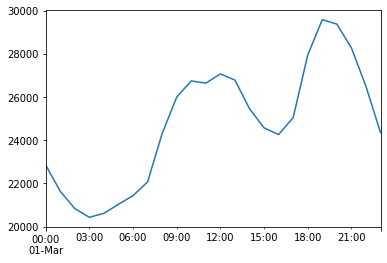

In [7]:
s.plot()

<br>

### Retrieving Latest Demand Data

We now want to repeat the requests for demand data over each country from a set time to the present, we'll test if this works just putting the start and end we want

In [8]:
start = pd.Timestamp('2020-03-01')
end = pd.Timestamp.now().floor('H')
    
s = client.query_country_load(entsoe_zone, start=start, end=end)

s

2020-03-01 00:00:00+00:00    22848.0
2020-03-01 01:00:00+00:00    21638.0
2020-03-01 02:00:00+00:00    20833.0
2020-03-01 03:00:00+00:00    20431.0
2020-03-01 04:00:00+00:00    20616.0
                              ...   
2020-03-23 01:00:00+00:00    20027.0
2020-03-23 02:00:00+00:00    19599.0
2020-03-23 03:00:00+00:00    19596.0
2020-03-23 04:00:00+00:00    20020.0
2020-03-23 05:00:00+00:00    22090.0
Length: 533, dtype: float64

<br>

Unfortunately we can see that the data doesn't go up to the end date we requested, this is because ENTSOE places a limit on the timespan you can request. To avoid this problem we'll create a function that breaks our desired timespan into chunks which ENTSOE can handle.

In [9]:
def get_start_end_chunks(start, end):
    start_end_chunks = []

    chunk_start = start

    while (end - chunk_start).days > 0:
        ## Determining chunk end
        chunk_end = chunk_start + pd.Timedelta(days=15)
        
        if (end - chunk_end).days < 0:
            chunk_end = end

        ## assigning chunk and resetting chunk start
        start_end_chunks += [(chunk_start, chunk_end)]

        chunk_start = chunk_end

    return start_end_chunks

start = pd.Timestamp('2020-03-02')
end = pd.Timestamp('2020-03-23') # pd.Timestamp.now().floor('H')

dt_rng = pd.date_range(start, end, freq='15T', tz='UTC')
start_end_chunks = get_start_end_chunks(start, end)

start_end_chunks

[(Timestamp('2020-03-02 00:00:00'), Timestamp('2020-03-17 00:00:00')),
 (Timestamp('2020-03-17 00:00:00'), Timestamp('2020-03-23 00:00:00'))]

<br>

We can then iterate over the list of date range chunks and countries, collecting data for each

In [10]:
df_demand = pd.DataFrame(index=dt_rng)

for country in track(countries):
    s_country = pd.Series()
    
    for start, end in start_end_chunks:
        entsoe_zone = country_meta[country]['entsoe_zone']

        s_country_chunk = client.query_country_load(entsoe_zone, start=start, end=end)
        s_country = s_country.append(s_country_chunk)
        
    df_demand[country] = s_country
    
df_demand = df_demand.dropna(how='all')
    
df_demand.head(3)

 [████████████████████████████████████████████████████████████] 6/6 [00:09<00:01, 1.56s/it]

france  germany    italy   norway    spain  \
2020-03-02 00:00:00+00:00  56773.0  46904.0  21485.0  17034.0  22644.0   
2020-03-02 00:15:00+00:00      NaN  46638.0      NaN      NaN      NaN   
2020-03-02 00:30:00+00:00      NaN  46213.0      NaN      NaN      NaN   

                                UK  
2020-03-02 00:00:00+00:00  30184.0  
2020-03-02 00:15:00+00:00      NaN  
2020-03-02 00:30:00+00:00  30704.0

In [11]:
df_demand.tail(3)

france  germany    italy   norway    spain       UK
2020-03-22 22:30:00+00:00     NaN      NaN      NaN      NaN      NaN  31799.0
2020-03-22 23:00:00+00:00     NaN      NaN  19981.0  16328.0  22553.0  29204.0
2020-03-22 23:30:00+00:00     NaN      NaN      NaN      NaN      NaN  27694.0

<br>

We can check that it handled the chunk splicing correctly

In [12]:
df_demand['2020-03-15 23:30':'2020-03-16 00:30']

france  germany    italy   norway    spain  \
2020-03-15 23:30:00+00:00      NaN  46248.0      NaN      NaN      NaN   
2020-03-15 23:45:00+00:00      NaN  45657.0      NaN      NaN      NaN   
2020-03-16 00:00:00+00:00  50272.0  44935.0  20039.0  15620.0  22023.0   
2020-03-16 00:15:00+00:00      NaN  44664.0      NaN      NaN      NaN   
2020-03-16 00:30:00+00:00      NaN  44573.0      NaN      NaN      NaN   

                                UK  
2020-03-15 23:30:00+00:00  28093.0  
2020-03-15 23:45:00+00:00      NaN  
2020-03-16 00:00:00+00:00  27762.0  
2020-03-16 00:15:00+00:00      NaN  
2020-03-16 00:30:00+00:00  28351.0

<br>

### Processing Data

We're now going to create an xarray dataset that contains all of our demand data

In [13]:
## Converting df to ds
df_demand_unstacked = df_demand.unstack()
df_demand_unstacked.index.names = ['country', 'datetime']

ds = xr.DataArray.from_series(df_demand_unstacked).to_dataset(name='demand')

## Cleaning datetime and demand
ds.datetime.values = pd.to_datetime(ds.datetime.values)
ds['demand'].values = ds['demand'].values

## Handling shuffling of country names
country_maxs = df_demand_unstacked.groupby([x[0] for x in list(df_demand_unstacked.index)]).max()
max_2_country = dict(zip(country_maxs.values, country_maxs.keys()))
ds.country.values = ds['demand'].max(dim='datetime').to_series().map(max_2_country).values.astype(str)

ds

<xarray.Dataset>
Dimensions:   (country: 6, datetime: 1949)
Coordinates:
  * country   (country) <U7 'UK' 'france' 'germany' 'italy' 'norway' 'spain'
  * datetime  (datetime) datetime64[ns] 2020-03-02 ... 2020-03-22T23:30:00
Data variables:
    demand    (country, datetime) float64 3.018e+04 nan ... 2.255e+04 nan

<br>

This can be indexed like a Pandas dataframe, however, unlike Pandas it can be scaled to nd-arrays rather than just 2d ones

In [14]:
ds['demand'].loc['france', '2020-03-02'].dropna(dim='datetime')

<xarray.DataArray 'demand' (datetime: 48)>
array([30184., 30704., 30760., 30530., 30170., 30197., 29857., 29580.,
       30035., 30175., 31526., 33115., 36811., 39546., 42025., 43313.,
       44489., 44956., 43819., 45539., 45144., 45356., 43792., 43636.,
       43130., 42569., 42287., 41662., 40685., 40396., 41018., 41248.,
       43283., 44338., 46607., 47655., 49563., 49918., 49317., 47971.,
       46628., 44884., 42930., 40629., 37664., 35583., 32381., 30541.])
Coordinates:
    country   <U7 'UK'
  * datetime  (datetime) datetime64[ns] 2020-03-02 ... 2020-03-02T23:30:00

<br>

We can similarly store our metadata in a dataset

In [15]:
df_country_meta = pd.DataFrame(country_meta).T
df_country_meta.index.name = 'country'

ds_country_meta = xr.Dataset.from_dataframe(df_country_meta)

ds_country_meta

<xarray.Dataset>
Dimensions:       (country: 6)
Coordinates:
  * country       (country) object 'france' 'germany' 'italy' ... 'spain' 'UK'
Data variables:
    country_code  (country) object 'FR' 'DE' 'IT' 'NO' 'ES' 'GB'
    timezone      (country) object 'Europe/Paris' ... 'Europe/London'
    entsoe_zone   (country) object '10YFR-RTE------C' ... '10YGB----------A'
    resolution    (country) object 'H' '15T' 'H' 'H' 'H' '30T'

<br>

These can then be combined

In [16]:
ds = ds.combine_first(ds_country_meta)

ds

<xarray.Dataset>
Dimensions:       (country: 6, datetime: 1949)
Coordinates:
  * country       (country) <U7 'UK' 'france' 'germany' 'italy' 'norway' 'spain'
  * datetime      (datetime) datetime64[ns] 2020-03-02 ... 2020-03-22T23:30:00
Data variables:
    demand        (country, datetime) float64 3.018e+04 nan ... 2.255e+04 nan
    country_code  (country) object 'FR' 'DE' 'IT' 'NO' 'ES' 'GB'
    timezone      (country) object 'Europe/Paris' ... 'Europe/London'
    entsoe_zone   (country) object '10YFR-RTE------C' ... '10YGB----------A'
    resolution    (country) object 'H' '15T' 'H' 'H' 'H' '30T'

<br>

The great advantage in this is that we can hold each country's demand data ...

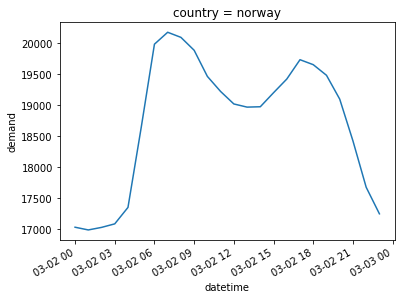

In [17]:
ds['demand'].loc['norway', '2020-03-02'].dropna(dim='datetime').plot()

<br>

... In the same dataset that holds its metadata

In [18]:
ds['timezone'].loc['norway'].item()

'Europe/Madrid'

<br>

### Data Quality Assurance

We'll quickly visualise the data to see if anything else looks off

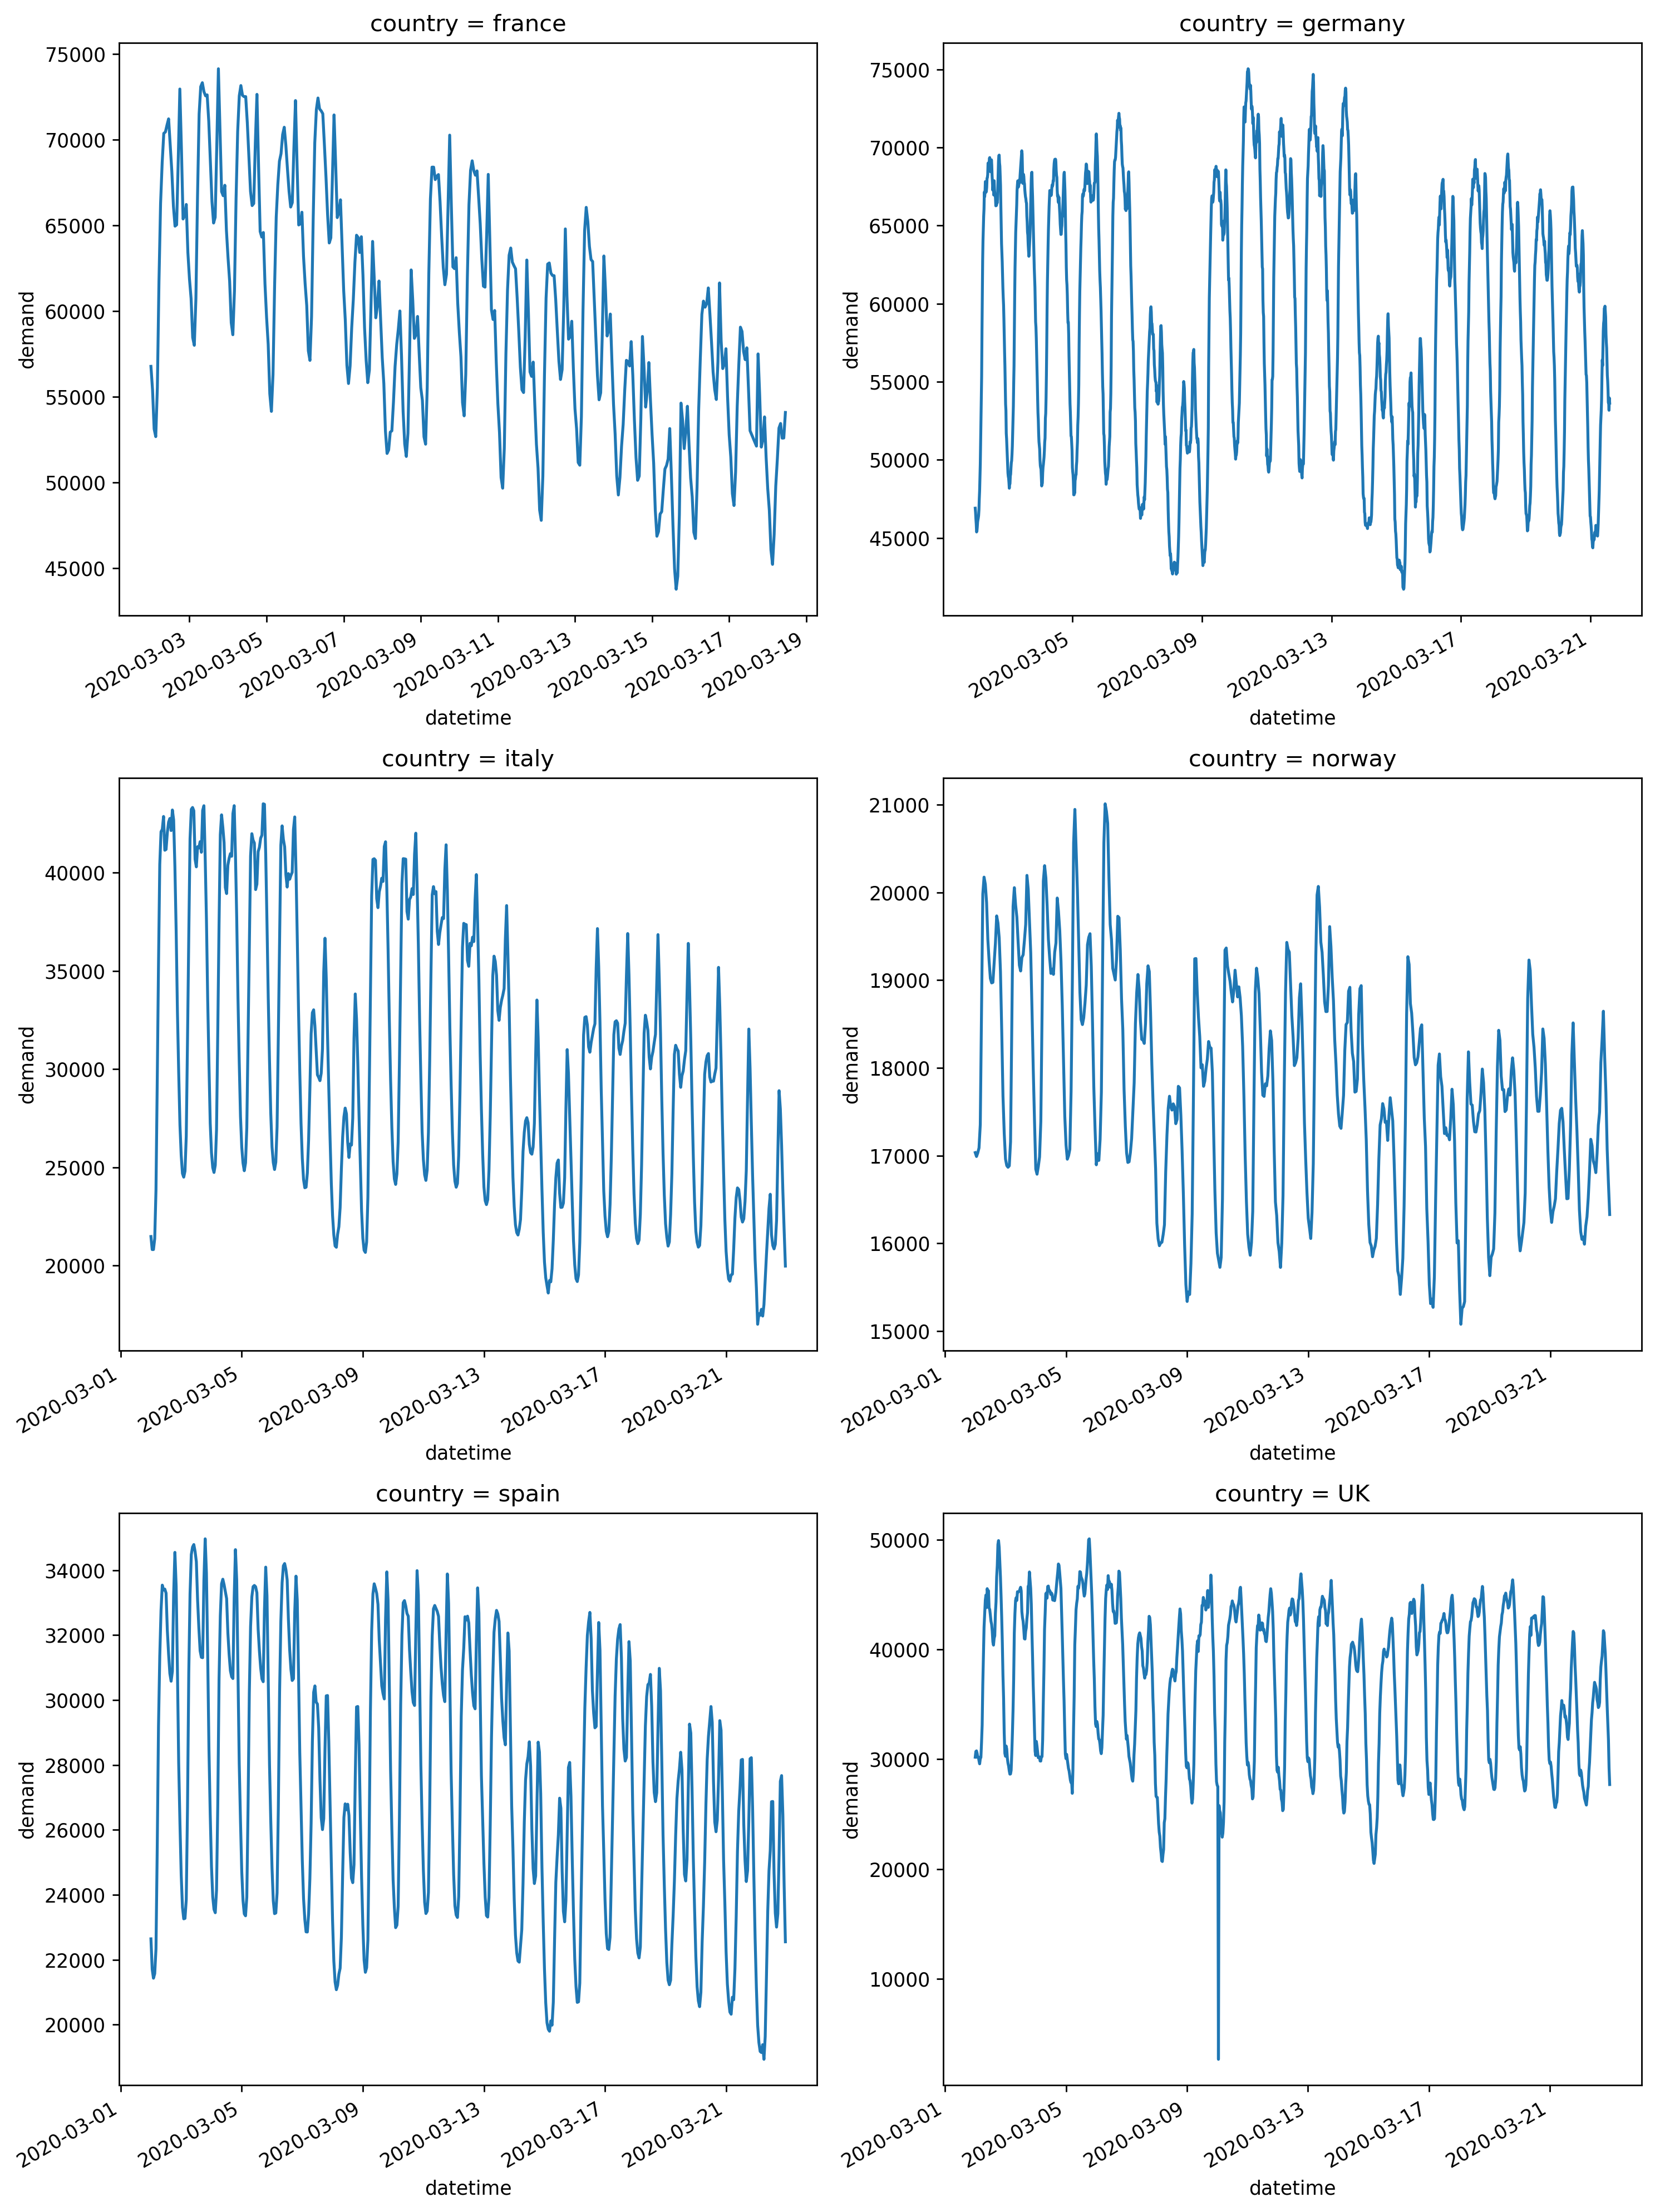

In [19]:
fig, axs = plt.subplots(dpi=250, nrows=3, ncols=2, figsize=(12, 16))
axs = axs.flatten()

for ax_idx, country in enumerate(countries):
    ds.sel(country=country)['demand'].dropna(dim='datetime').plot(ax=axs[ax_idx])
    
fig.tight_layout()

<br>

IT looks like there's an outlier in the UK dataset, we'll correct for this by setting it to na and then interpolating. This will also interpolate over the 

In [20]:
country = 'UK'

datetime = (ds
            .where(ds['demand'].sel(country=country)==ds['demand'].sel(country=country).min())
            .dropna('country', how='all')
            .dropna('datetime')
            .sel(country=country)
            .coords
            .to_index()
            [0]
           )

ds['demand'].loc[country, datetime] = np.nan
ds['demand'].loc[country, datetime] = ds['demand'].interpolate_na('datetime').loc[country, datetime]

ds['demand'].loc[country, datetime]

<xarray.DataArray 'demand' ()>
array(26647.5)
Coordinates:
    country   <U7 'UK'
    datetime  datetime64[ns] 2020-03-10T01:00:00

<br>

We can now see that the datasets look far closer to what we'd expect

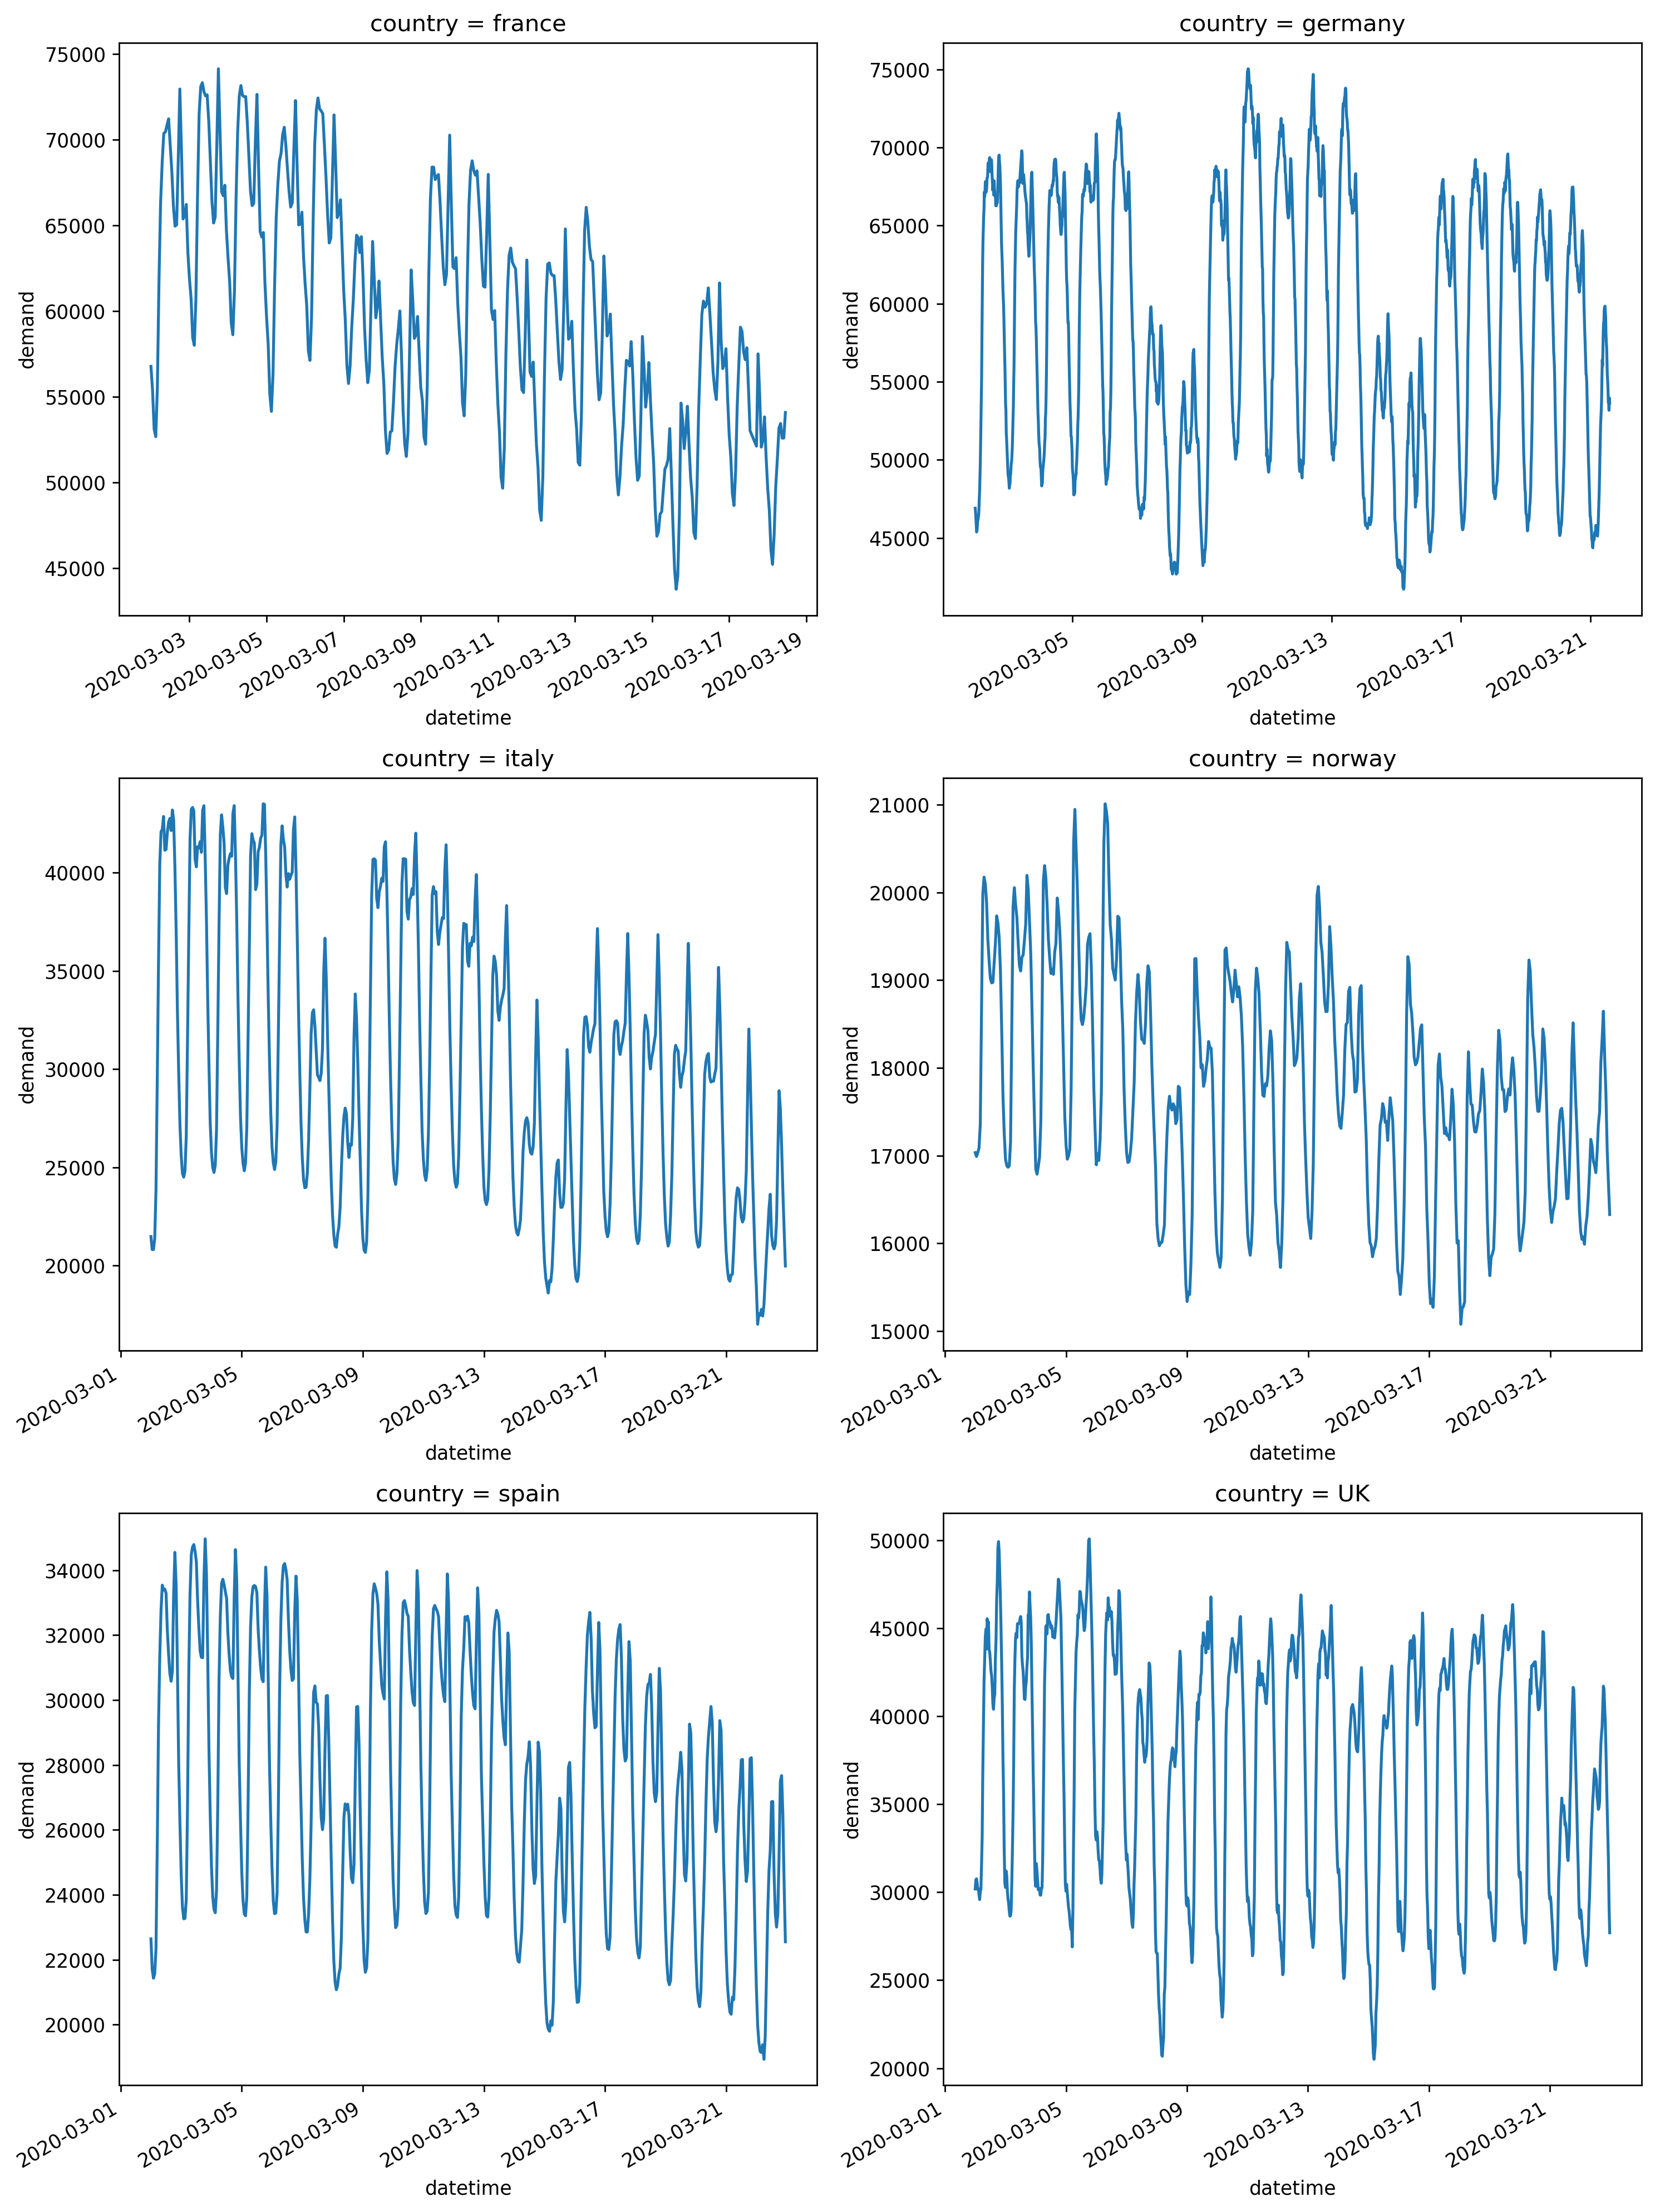

In [21]:
fig, axs = plt.subplots(dpi=250, nrows=3, ncols=2, figsize=(12, 16))
axs = axs.flatten()

for ax_idx, country in enumerate(countries):
    ds.sel(country=country)['demand'].dropna(dim='datetime').plot(ax=axs[ax_idx])
    
fig.tight_layout()

<br>

### Documenting & Saving

Alongside being able to store n-dimensional data arrays, xarray allows us to add metadata to our datasets

In [22]:
ds_attrs = {
    'source' : 'ENTSOE',
    'url' : 'https://transparency.entsoe.eu',
    'desc' : 'Total electricity demand of major European countries during onset of the Coronavirus crisis',
}

ds.attrs = ds_attrs

ds

<xarray.Dataset>
Dimensions:       (country: 6, datetime: 1949)
Coordinates:
  * country       (country) <U7 'UK' 'france' 'germany' 'italy' 'norway' 'spain'
  * datetime      (datetime) datetime64[ns] 2020-03-02 ... 2020-03-22T23:30:00
Data variables:
    demand        (country, datetime) float64 3.018e+04 nan ... 2.255e+04 nan
    country_code  (country) object 'FR' 'DE' 'IT' 'NO' 'ES' 'GB'
    timezone      (country) object 'Europe/Paris' ... 'Europe/London'
    entsoe_zone   (country) object '10YFR-RTE------C' ... '10YGB----------A'
    resolution    (country) object 'H' '15T' 'H' 'H' 'H' '30T'
Attributes:
    source:   ENTSOE
    url:      https://transparency.entsoe.eu
    desc:     Total electricity demand of major European countries during ons...

<br>

Which can also be added for individual data-arrays

In [23]:
demand_attrs = {
    'units' : 'MW',
    'desc' : 'Total electricity demand',
}

ds.demand.attrs = demand_attrs

ds['demand']

<xarray.DataArray 'demand' (country: 6, datetime: 1949)>
array([[30184.,    nan, 30704., ..., 31799., 29204., 27694.],
       [56773.,    nan,    nan, ...,    nan,    nan,    nan],
       [46904., 46638., 46213., ...,    nan,    nan,    nan],
       [21485.,    nan,    nan, ...,    nan, 19981.,    nan],
       [17034.,    nan,    nan, ...,    nan, 16328.,    nan],
       [22644.,    nan,    nan, ...,    nan, 22553.,    nan]])
Coordinates:
  * country   (country) <U7 'UK' 'france' 'germany' 'italy' 'norway' 'spain'
  * datetime  (datetime) datetime64[ns] 2020-03-02 ... 2020-03-22T23:30:00
Attributes:
    units:    MW
    desc:     Total electricity demand

<br>

Finally we can save the dataset as a NetCDF file

In [24]:
ds.to_netcdf('data/demand.nc')

<br>

### Visualisation

To recreate the visualisation from the FT we'll need to plot multiple weeks on the same axis. To do this we'll shift all weeks so that they have the same start date as the first week, then we'll set the column names to the date at the start of the week in question. For the time-being this means the x axis will be formatted with incorrect dates but we'll fix this later on.

In [25]:
def get_country_demand_week_comparison(da_country_demand):
    idx_week_of_year = da_country_demand.datetime.dt.weekofyear
    weeks = sorted(list(set(idx_week_of_year.values)))

    df_country_demand = pd.DataFrame()

    for week in weeks:
        s_country_demand_week = (da_country_demand
                                 .where(idx_week_of_year==week)
                                 .dropna('datetime')
                                 .to_series()
                                )

        week_start_str = s_country_demand_week.index.min().strftime('%B %d')
        s_country_demand_week.index = s_country_demand_week.index - pd.Timedelta(weeks=week-min(weeks))

        df_country_demand[week_start_str] = s_country_demand_week

    df_country_demand = df_country_demand.interpolate(limit_direction='backward')
    
    return df_country_demand

country = 'UK'

da_country_demand = ds.sel(country=country)['demand'].dropna(dim='datetime')
df_country_demand_week_comparison = get_country_demand_week_comparison(da_country_demand)

num_wks = df_country_demand_week_comparison.shape[1]

df_country_demand_week_comparison.head()

March 02  March 09  March 16
datetime                                         
2020-03-02 00:00:00   30184.0   29220.0   27762.0
2020-03-02 00:30:00   30704.0   29689.0   28351.0
2020-03-02 01:00:00   30760.0   29563.0   29481.0
2020-03-02 01:30:00   30530.0   29005.0   28824.0
2020-03-02 02:00:00   30170.0   28206.0   27783.0

<br>

We can visualise the data and specify how it looks through various matplotlib arguments, such as with the fontsize specified in the title

Text(0.5, 1.0, 'UK')

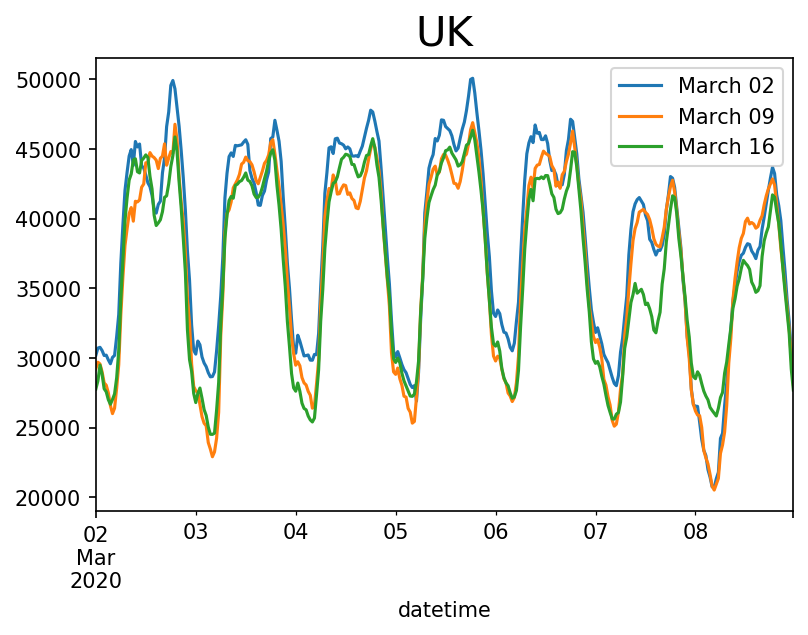

In [26]:
fig, ax = plt.subplots(dpi=150)

df_country_demand_week_comparison.plot(ax=ax)

ax.set_title('UK', fontdict={'fontsize':20})

<br>

However, we want to be able to reuse the styles we've use in our plots, for this we can turn to Matplotlib stylesheets. We'll first see what stylesheets Matplotlib already has available.

In [27]:
plt.style.available[:5]

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight']

<br>

We'll see how our plot looks using the <i>fivethirtyeight</i> style

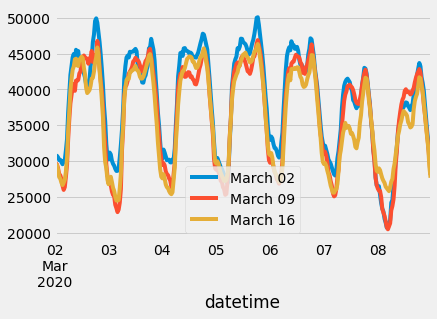

In [28]:
plt.style.use('fivethirtyeight')

df_country_demand_week_comparison.plot()

<br>

Before we go any further lets create a mini lambda function that can reset our style to the default parameters

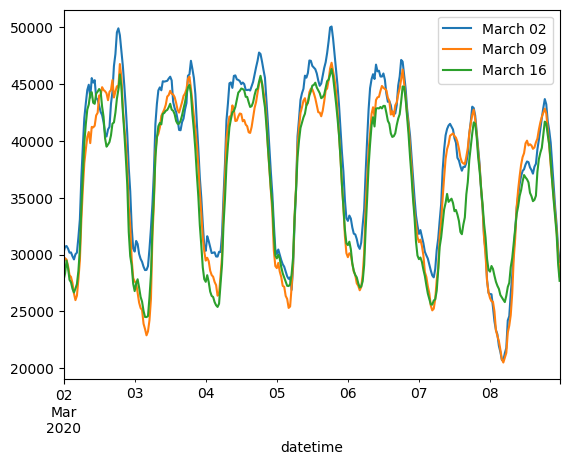

In [29]:
reset_mpl_style = lambda: mpl.rcParams.update(mpl.rcParamsDefault)

reset_mpl_style()

df_country_demand_week_comparison.plot()

<br>

We want to start making our own stylesheet that'll match the design of the plot we want to recreate, to ensure we can replicate this at a later date we'll save the parameters in a style sheet. 

To start with we'll recreate the stylesheet file below:

<img src="img/tutorial/FT_stylesheet.png" width=200></img>

<br>

To do this we'll begin by creating helper functions that will generate the stylesheet text from a dictionary of the parameter names and values ...


In [30]:
def create_style_txt(style_dict):
    style_txt = ''

    for key, value in style_dict.items():
        style_txt += f'{key} : {value}\n'
        
    style_txt = style_txt[:-1]
        
    return style_txt

FT_style = {
    'lines.linewidth' : '5',
}

FT_style_txt = create_style_txt(FT_style)
    
print(FT_style_txt)

lines.linewidth : 5


<br>

... as well as save the generated stylesheet text into a Matplotlib stylesheet file

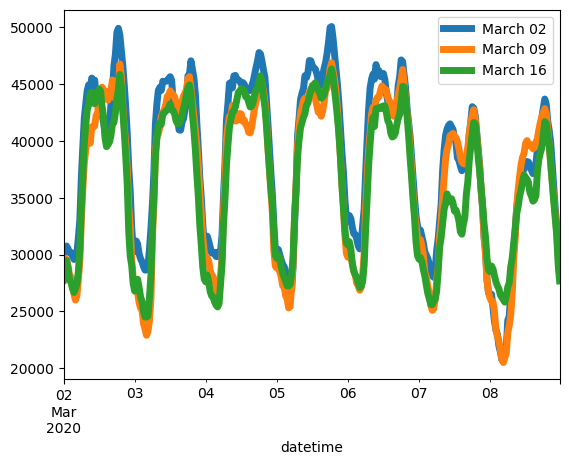

In [31]:
def save_n_set_stylesheet(stylepath, style_txt):
    with open(stylepath, 'w') as style_file:
        print(style_txt, file=style_file)
    
    plt.style.use(stylepath)
    
FT_stylepath = f"{os.getcwd()}/FT.mplstyle"

save_n_set_stylesheet(FT_stylepath, FT_style_txt)

df_country_demand_week_comparison.plot()

<br>

To extract the colours that were used in the original FT graph you can use a <a href="https://chrome.google.com/webstore/detail/colorpick-eyedropper/ohcpnigalekghcmgcdcenkpelffpdolg">color pick eyedropper</a>. We use this to grab the colours for the lines representing each week.

<img src="img/tutorial/color_pick_eyedropper.png" width=350></img>

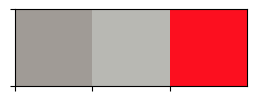

In [32]:
rgb_2_plt_tuple = lambda r, g, b: tuple([x/255 for x in (r, g, b)])

dark_grey = rgb_2_plt_tuple(160, 155, 150)
light_grey = rgb_2_plt_tuple(184, 184, 179)
red = rgb_2_plt_tuple(252, 15, 31)

lines_palette = [dark_grey, light_grey, red]

sns.palplot(lines_palette)

<br>

Next we'll define our stylesheet

In [33]:
FT_style = {
    ## Figure
    'figure.facecolor' : rgb_2_plt_tuple(255, 241, 230),
    
    ## Axes
    'axes.facecolor' : rgb_2_plt_tuple(255, 241, 230),
    'axes.grid' : True,
    'axes.grid.which' : 'major',
    'xtick.color' : rgb_2_plt_tuple(75, 75, 75),
    'ytick.color' : rgb_2_plt_tuple(75, 75, 75),
    'axes.spines.top' : False,
    'axes.spines.right' : False,
    'axes.spines.bottom' : False,
    'axes.spines.left' : False,
    
    ## Ticks
    'xtick.bottom' : False,
    'ytick.left' : False,
    
    ## Patches
    'patch.facecolor' : rgb_2_plt_tuple(253, 168, 163),
    
    ## Saving
    'savefig.facecolor' : rgb_2_plt_tuple(255, 241, 230),
}

reset_mpl_style()

FT_style_txt = create_style_txt(FT_style)
save_n_set_stylesheet(FT_stylepath, FT_style_txt)

<br>

Now finally we're ready to create our version of the visualisation

Wall time: 1.34 s


Text(0, 1.085, 'Hourly energy demand (GW), last three weeks')

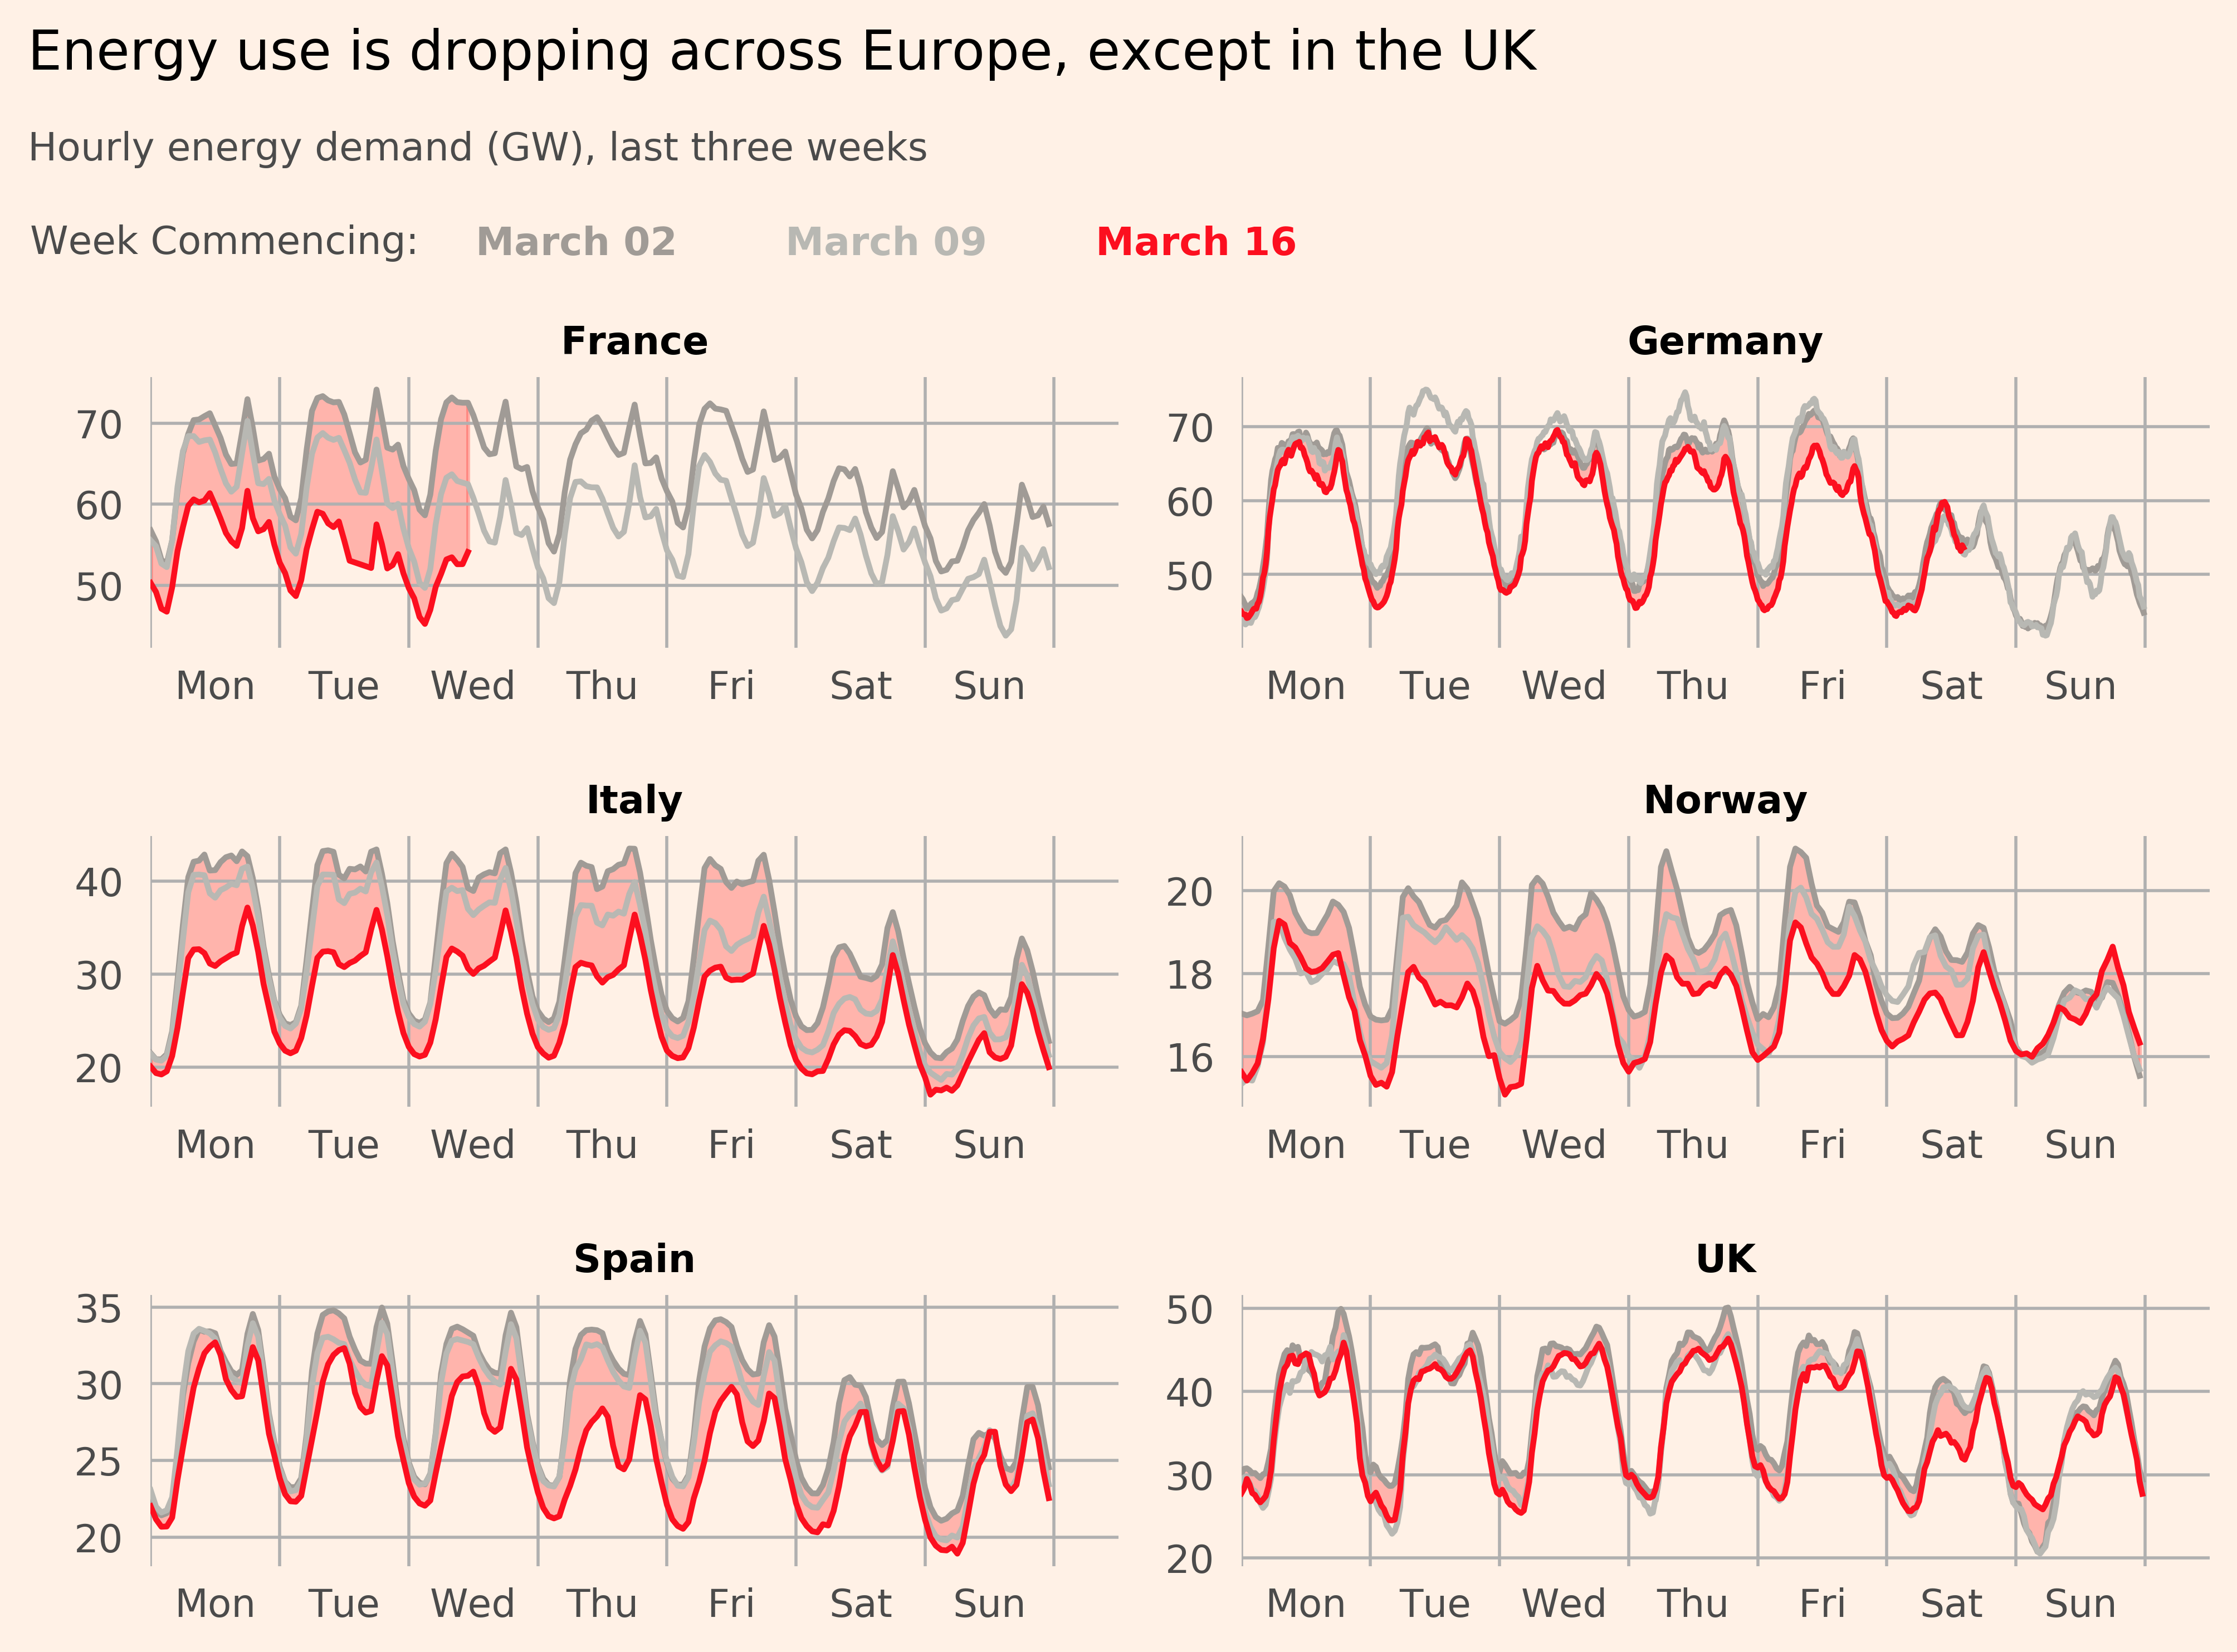

In [34]:
%%time

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig, axs = plt.subplots(dpi=500, nrows=3, ncols=2, figsize=(8, 5))
axs = axs.flatten()

for ax_idx, country in enumerate(countries):
    ax = axs[ax_idx]
    
    da_country_demand = ds.sel(country=country)['demand'].dropna(dim='datetime')
    df_country_demand_week_comparison = get_country_demand_week_comparison(da_country_demand)

    num_wks = df_country_demand_week_comparison.shape[1]
    
    (df_country_demand_week_comparison/1000).plot(legend=False, ax=ax, color=lines_palette)
    ax.fill_between(df_country_demand_week_comparison.index, df_country_demand_week_comparison.iloc[:, -1]/1000, df_country_demand_week_comparison.iloc[:, 0]/1000, color='red', alpha=0.25, zorder=0)

    ## Removing existing x label
    ax.set_xlabel('')
    
    ## Setting grid lines and tick labels
    ax.xaxis.set_ticks(pd.date_range('2020-03-02 12', '2020-03-09 12', freq='D'), minor=True)
    ax.xaxis.set_ticks(pd.date_range('2020-03-02', '2020-03-09', freq='D'), minor=False)
    ax.set_xticklabels(labels, minor=True)
    ax.set_xticklabels(['']*7, minor=False)
    
    ## Setting tick locators
    val_rng = (df_country_demand_week_comparison.max().max()-df_country_demand_week_comparison.min().min())/1000
    
    if val_rng > 20: 
        n = 10
    elif val_rng > 10:
        n = 5
    else:
        n = 2
        
    ax.yaxis.set_major_locator(plt.MultipleLocator(n))
    
    ## Setting title
    if len(country) > 2:
        title = country.capitalize()
    else:
        title = country
        
    ax.set_title(title, fontdict={'weight':'bold', 'fontsize':10})
    
fig.tight_layout(pad=1.2, h_pad=2)

## Legend
leg = axs[0].legend(frameon=False, bbox_to_anchor=(1.22, 1.9), ncol=num_wks, 
                    prop={'size':10, 'weight':'bold'}, columnspacing=0, title='Week Commencing:')

leg._legend_box.align = 'left'
leg.get_title().set_position((-605, -100))
leg.get_title().set_color(rgb_2_plt_tuple(75, 75, 75))

for idx, text in enumerate(leg.get_texts()):
    text.set_color(lines_palette[idx])
for item in leg.legendHandles:
    item.set_visible(False)

plt.figtext(0, 1.15, 'Energy use is dropping across Europe, except in the UK', fontsize=14)
plt.figtext(0, 1.085, 'Hourly energy demand (GW), last three weeks', fontsize=10, color=rgb_2_plt_tuple(75, 75, 75))

#fig.savefig('img/coronavirus_energy_drop_off.png')